In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro, mannwhitneyu, ttest_ind
import numpy as np

# # Load the data
# data1 = pd.read_csv('../results/experiment_results_melle.csv')
# data2 = pd.read_csv('../results/experiment_results_scott.csv')
# data3 = pd.read_csv('../results/experiment_results_matthijs.csv')

data = pd.read_csv('../results/experiment_results_scott.csv')
data['power_watts'] = data['energy_joules'] / data['execution_time_sec']

data.head()

,run_type,run_number,energy_joules,execution_time_sec,power_watts
0,gpu,2,950.909912,46.65394,20.382199
1,cpu,28,5134.501099,106.29025,48.306417
2,cpu,9,5440.299072,112.94961,48.165718
3,cpu,5,5020.210205,106.25003,47.249024
4,cpu,8,5107.006470,105.74806,48.294091


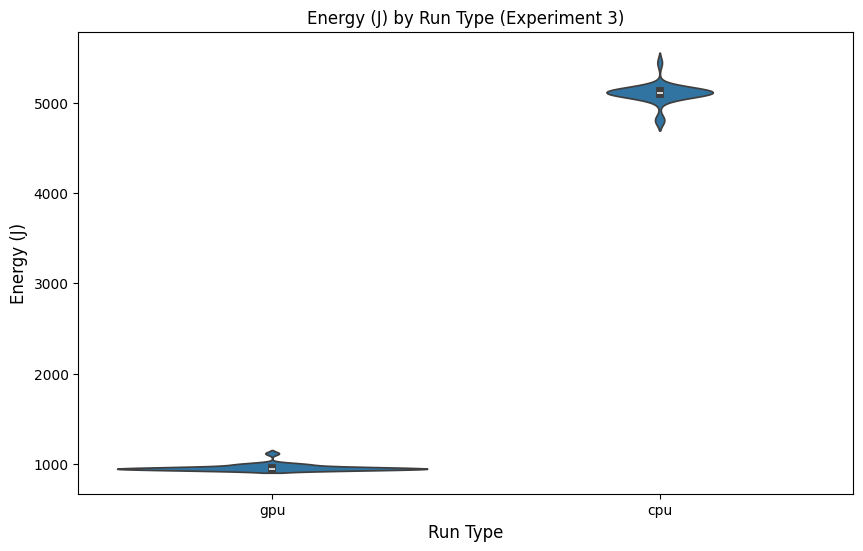

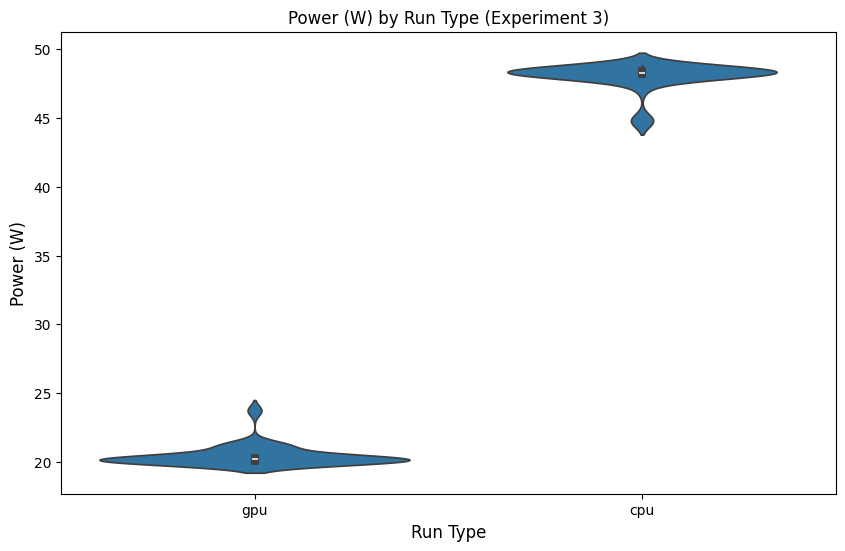

In [97]:

# Violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='run_type', y='energy_joules', data=data)
plt.title('Energy (J) by Run Type (Experiment 3)')
plt.xlabel('Run Type', fontsize=12)
plt.ylabel('Energy (J)', fontsize=12)
plt.show()

plt.figure(figsize=(10, 6))
sns.violinplot(x='run_type', y='power_watts', data=data)
plt.title('Power (W) by Run Type (Experiment 3)')
plt.xlabel('Run Type', fontsize=12)
plt.ylabel('Power (W)', fontsize=12)
plt.show()


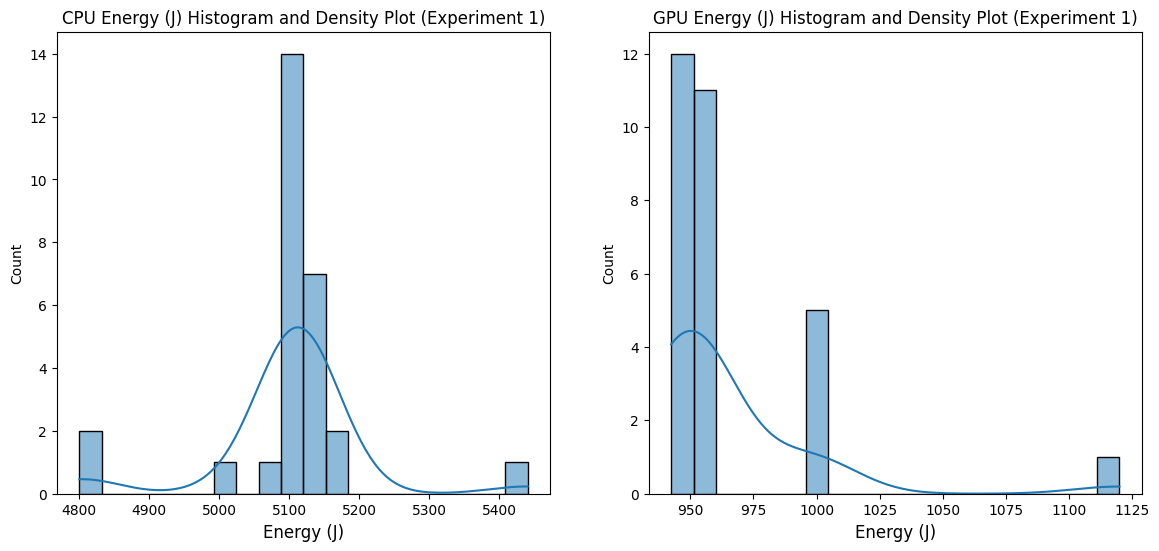

In [103]:

# Histograms and density plots
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(data[data['run_type'] == 'cpu']['energy_joules'], kde=True, bins=20)
plt.title('CPU Energy (J) Histogram and Density Plot (Experiment 1)')
plt.xlabel('Energy (J)', fontsize=12)

plt.subplot(1, 2, 2)
sns.histplot(data[data['run_type'] == 'gpu']['energy_joules'], kde=True, bins=20)
plt.title('GPU Energy (J) Histogram and Density Plot (Experiment 1)')
plt.xlabel('Energy (J)', fontsize=12)

plt.show()

In [99]:

# Shapiro-Wilk test for normality
cpu_data = data[data['run_type'] == 'cpu']['energy_joules']
gpu_data = data[data['run_type'] == 'gpu']['energy_joules']

shapiro_cpu = shapiro(cpu_data)
shapiro_gpu = shapiro(gpu_data)

print(f'Shapiro-Wilk Test for CPU: W={shapiro_cpu.statistic}, p-value={shapiro_cpu.pvalue}')
if shapiro_cpu.pvalue < 0.05:
    print('CPU data is NOT normally distributed')
else:
    print('CPU data is normally distributed')
print(f'Shapiro-Wilk Test for GPU: W={shapiro_gpu.statistic}, p-value={shapiro_gpu.pvalue}')
if shapiro_gpu.pvalue < 0.05:
    print('GPU data is NOT normally distributed')
else:
    print('GPU data is normally distributed')

Shapiro-Wilk Test for CPU: W=0.6621284486142135, p-value=8.675941553197195e-07
CPU data is NOT normally distributed
Shapiro-Wilk Test for GPU: W=0.5468214049273163, p-value=2.490080464516368e-08
GPU data is NOT normally distributed


If data is not normally distributed try removing outliers. If date is normally distributed skip this cell.

In [100]:
cpu_data_size = len(cpu_data)
gpu_data_size = len(gpu_data)
# remove outliers
cpu_data = cpu_data[cpu_data.between(cpu_data.quantile(0.05), cpu_data.quantile(0.95))]
gpu_data = gpu_data[gpu_data.between(gpu_data.quantile(0.05), gpu_data.quantile(0.95))]

print(f'CPU data: {cpu_data_size} -> {len(cpu_data)}')
print(f'GPU data: {gpu_data_size} -> {len(gpu_data)}')
# test if data is normally distributed
shapiro_cpu = shapiro(cpu_data)
shapiro_gpu = shapiro(gpu_data)

print(f'Shapiro-Wilk Test for CPU: W={shapiro_cpu.statistic}, p-value={shapiro_cpu.pvalue}')
if shapiro_cpu.pvalue < 0.05:
    print('CPU data is not normally distributed')
else:
    print('CPU data is normally distributed')
    
print(f'Shapiro-Wilk Test for GPU: W={shapiro_gpu.statistic}, p-value={shapiro_gpu.pvalue}')
if shapiro_gpu.pvalue < 0.05:
    print('GPU data is not normally distributed')
else:
    print('GPU data is normally distributed')

CPU data: 28 -> 24
GPU data: 29 -> 25
Shapiro-Wilk Test for CPU: W=0.8767462000578112, p-value=0.007151676801845407
CPU data is not normally distributed
Shapiro-Wilk Test for GPU: W=0.6178100626072826, p-value=6.827262094418441e-07
GPU data is not normally distributed


If data is normally distributed:

In [101]:

# Welch's t-test
t_test = ttest_ind(cpu_data, gpu_data, equal_var=False)

mean_cpu = np.mean(cpu_data)
mean_gpu = np.mean(gpu_data)
mean_diff = mean_gpu - mean_cpu
percent_change = (mean_diff / mean_cpu) * 100
cohen_d = (mean_diff) / np.sqrt((np.std(cpu_data) ** 2 + np.std(gpu_data) ** 2) / 2)

print(f'Welch\'s t-test: t-statistic={t_test.statistic}, p-value={t_test.pvalue}')
print(f'Mean CPU: {mean_cpu}')
print(f'Mean GPU: {mean_gpu}')
print(f'Mean Difference: {mean_diff}')
print(f'Percent Change: {percent_change}%')
print(f'Cohen\'s d: {cohen_d}')

Welch's t-test: t-statistic=657.1854217539285, p-value=4.058099515842992e-83
Mean CPU: 5108.393320719401
Mean GPU: 957.8951416015625
Mean Difference: -4150.498179117839
Percent Change: -81.24860241836929%
Cohen's d: -192.50214780157648


If data is not normally distributed:

In [102]:
# Mann-Whitney U test
u_test = mannwhitneyu(cpu_data, gpu_data, alternative='two-sided')

median_cpu = np.median(cpu_data)
median_gpu = np.median(gpu_data)
median_diff = median_gpu - median_cpu

# Calculate percentage of pairs
n1 = len(cpu_data)
n2 = len(gpu_data)
U = u_test.statistic
percent_pairs = U / (n1 * n2) * 100

# Common language effect size
cl_effect_size = U / (n1 * n2)

print(f'Mann-Whitney U test: U-statistic={u_test.statistic}, p-value={u_test.pvalue}')
print(f'Median CPU: {median_cpu}')
print(f'Median GPU: {median_gpu}')
print(f'Median Difference: {median_diff}')
print(f'Percentage of Pairs: {percent_pairs}%')
print(f'Common Language Effect Size: {cl_effect_size}')

Mann-Whitney U test: U-statistic=600.0, p-value=2.0984103756662974e-09
Median CPU: 5106.519836425781
Median GPU: 951.9063720703124
Median Difference: -4154.613464355469
Percentage of Pairs: 100.0%
Common Language Effect Size: 1.0
